<center><img src="Fig/UGA.png" width="30%" height="30%"></center>
<center><h3>Master of Science in Industrial and Applied Mathematics (MSIAM)  - 1st year</h3></center>
<hr>
<center><h1>Numerical Optimization</h1></center>
<center><h2>Lab 5: Optimization for ML </h2></center>


---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import timeit
import logistic_regression_ionosphere as pb
import matplotlib.pyplot as plt
%matplotlib inline

---

# Algorithms performance on practical problems

In this lab, we will investigate how to evaluate and display performance of optimization algorithms over a practical problem of machine learning: binary classification using logistic regression.</br>

## Machine Learning as an Optimization problem

We have some *data*  $\mathcal{D}$ consisting of $m$ *examples* $\{d_i\}$; each example consisting of a *feature* vector $a_i\in\mathbb{R}^d$ and an *observation* $b_i\in \mathcal{O}$: $\mathcal{D} = \{[a_i,b_i]\}_{i=1..m}$. In this lab, we will consider the <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.names">ionosphere</a> dataset.
 
The goal of *supervised learning* is to construct a predictor for the observations when given feature vectors.

A popular approach is based on *linear models* which are based on finding a *parameter* $x$ such that the real number $\langle a_i , x \rangle$ is used to predict the value of the observation through a *predictor function* $g:\mathbb{R}\to \mathcal{O}$: $g(\langle a_i , x \rangle)$ is the predicted value from $a_i$.

In order to find such a parameter, we use the available data and a *loss* $\ell$ that penalizes the error made between the predicted $g(\langle a_i , x \rangle)$ and observed $b_i$ values. For each example $i$, the corresponding error function for a parameter $x$ is $f_i(x) =   \ell( g(\langle a_i , x \rangle) ; b_i )$. Using the whole data, the parameter that minimizes the total error is the solution of the minimization problem

$$ \min_{x\in\mathbb{R}^d}  \frac{1}{m} \sum_{i=1}^m f_i(x) = \frac{1}{m} \sum_{i=1}^m  \ell( g(\langle a_i , x \rangle) ; b_i ). $$

## Binary Classification with Logisitic Regression

In our setup, the observations are binary: $\mathcal{O} = \{-1 , +1 \}$, and the *Logistic loss* is used to form the following optimization problem
\begin{align*}
\min_{x\in\mathbb{R}^d } f(x) := \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) + \frac{\lambda_2}{2} \|x\|_2^2.
\end{align*}
where the last term is added as a regularization (of type $\ell_2$, aka Tikhnov) to prevent overfitting.

Under some statistical hypotheses, $x^\star = \arg\min f(x)$ maximizes the likelihood of the labels knowing the features vector. Then, for a new point $d$ with features vector $a$, 
$$ p_1(a) = \mathbb{P}[d\in \text{ class }  +1] = \frac{1}{1+\exp(-\langle a;x^\star \rangle)} $$

Thus, from $a$, if $p_1(a)$ is close to $1$, one can decide that $d$ belongs to class $1$; and the opposite decision if $p(a)$ is close to $0$. Between the two, the appreciation is left to the data scientist depending on the application.

## Objective of the optimizer
 
Given oracles for the function and its gradient, as well as an upper-bound of the Lipschitz constant $L$ of the gradient, find a minimizer of $f$.
 

> You are given *all* oracles of $f$ (function, gradient, Hessian) in `logistic_regression_ionosphere.py` and several algorithms in `algoGradient.py`.

### Influence of strong convexity on the speed of the gradient method


> **Task 1**: Run the following  blocks for different values of parameter `lam2` of the problem. What do you notice in terms of speed of convergence, what is the reason?

In [3]:
from algoGradient import gradient_algorithm

#### Parameter we give at our algorithm
PREC    = 1e-5                     # Sought precision
ITE_MAX = 5000                     # Max number of iterations
x0      = np.zeros(pb.n)           # Initial point
step    = 1.0/pb.L

pb.lam2 = 0.1

##### gradient algorithm
x,x_tab = gradient_algorithm(pb.f , pb.f_grad , x0 , step , PREC , ITE_MAX )

------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 2339 iterations / 6.587449s -- final value: 0.394334




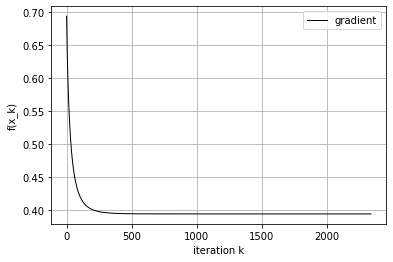

In [4]:
xs = range(x_tab.shape[0])
ys = [ pb.f(x_tab[ind]) for ind in xs ]

fig, ax = plt.subplots()
ax.plot(xs, ys, linewidth=1.0, linestyle='-', label='gradient', color='black')
ax.set(xlabel='iteration k', ylabel='f(x_k)')
ax.legend(); ax.grid()

# Accelerating poorly conditioned problems

While the addition of strong convexity accelerates the rate in practice, it usually result shift the solutions of the original problem. For a learning problem, it affects the accuracy.

In order to get faster convergences when the rate is slower, several acceleration techniques exist. We are going to present the most common in the following.

### Nesterov's fast gradient

In a series of papers published in the 80's, Yu. Nesterov proposed an acceleration technique in order to make the worst case rate of the gradient algorithm from $\mathcal{O}(1/k)$ to  $\mathcal{O}(1/k^2)$. This technique is now immensely popular, notably in the machine learning and image processing communities.
 

The iterations of Nesterov's accelerated gradient are as such:
$$ \left\{  \begin{array}{ll}  x_{k+1} = y_k - \gamma \nabla f(y_k) \\ y_{k+1} = x_{k+1} + \alpha_{k+1} (x_{k+1} - x_k )  \end{array}           \right. $$
with $\alpha_{k+1} = \frac{k+2}{k+3}$.
 
Although no clear intuition can be drawn, the extended point $y_{k+1}$ can be seen as an extension by inertia of the last points $x_{k+1}$, $x_k$.

*Note* that the original paper from Nesterov suggested more elaborate intertial parameters defined as
$$ \alpha_{k+1} = \frac{\lambda_k -1 }{\lambda_{k+1}} \text{ with } \lambda_0 = 0 \text{ and } \lambda_{k+1} = \frac{1+\sqrt{1+4\lambda_k^2}}{2} . $$
Those are "optimal" in some sense, but the above simpler ones provide the $\mathcal O(1/k^2)$ as well.

> **Task 2**: Implement Nesterov's fast gradient algorithm in function `fast_gradient_algorithm` of file `algoGradient.py`.

> **Task 3**: Run the constant stepsize and fast gradient algorithms and compare the convergence rates (for lam2 = 0.001).

In [5]:
from algoGradient import fast_gradient_algorithm

#### Parameter we give at our algorithm
PREC    = 1e-5                     # Sought precision
ITE_MAX = 50                     # Max number of iterations
x0      = np.zeros(pb.n)           # Initial point
step    = 1.0/pb.L

pb.lam2 = 0.001

x,x_tab    =      gradient_algorithm(pb.f , pb.f_grad , x0 , step , PREC , ITE_MAX )
xF,xF_tab  = fast_gradient_algorithm(pb.f , pb.f_grad , x0 , step , PREC , ITE_MAX )

------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 49 iterations / 0.170351s -- final value: 0.440997


------------------------------------
 Fast gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 49 iterations / 0.201213s -- final value: 0.693147




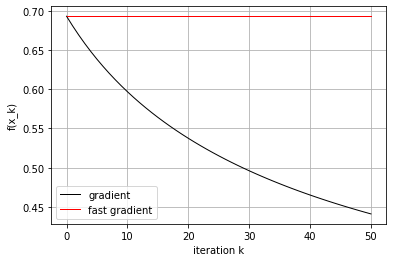

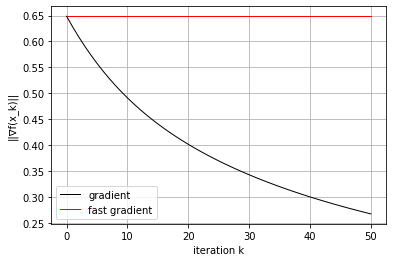

In [6]:
xs_grad = range(x_tab.shape[0])
xs_fastgrad = range(xF_tab.shape[0])

## Plot function values
ys_f_grad = [pb.f(x_tab[i]) for i in xs_grad]
ys_f_fastgrad = [pb.f(xF_tab[i]) for i in xs_fastgrad]

fig, ax = plt.subplots()
ax.plot(xs_grad, ys_f_grad, color="black", linewidth=1.0, linestyle="-",label='gradient')
ax.plot(xs_fastgrad, ys_f_fastgrad, color="red", linewidth=1.0, linestyle="-",label='fast gradient')
ax.set(xlabel='iteration k', ylabel='f(x_k)')
ax.legend(); ax.grid()

## Plot gradient norm
ys_normgrad_grad = [np.linalg.norm(pb.f_grad(x_tab[i])) for i in xs_grad]
ys_normgrad_fastgrad = [np.linalg.norm(pb.f_grad(xF_tab[i])) for i in xs_fastgrad]

fig, ax = plt.subplots()
ax.plot(xs_grad, ys_normgrad_grad, color="black", linewidth=1.0, linestyle="-",label='gradient')
ax.plot(xs_fastgrad, ys_normgrad_fastgrad, color="red", linewidth=1.0, linestyle="-",label='fast gradient')
ax.set(xlabel='iteration k', ylabel='||∇f(x_k)||')
ax.legend(); ax.grid()

---


### Other methods: line-search, BFGS


Other popular methods to accelerate convergence are:
* line-search: given a point $x_k$ and a (descent) direction $d_k$, the linesearch computes a *steplength* $\alpha_k$ and yields the following next iterate $x_k+\alpha_k d_k$. The steplength $\alpha_k$ is chosen such that $f(x_k+\alpha_k d_k)$ is sufficiently lower than $f(x_k)$ (*sufficient decrease* condition).
* BFGS which is a Quasi-Newton method in the sense that it approximates second order information in an online setting.

Wolfe's linesearch is implemented in `Scipy`'s <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html">`scipy.optimize.line_search`</a>. 

> **Task 4**: Implement the gradient algorithm with Wolfe's line-search in function `gradient_wolfe` of file `algoGradient.py`.

**BFGS.** (Broyden-Fletcher-Goldfarb-Shanno, 1970) The popular BFGS algorithm consist in performing the following iteration
$$ x_{k+1}=x_k - \gamma_k W_k \nabla f(x_k)$$
where $\gamma_k$ is given by Wolfe's line-search and positive definite matrix $W_k$ is computed as
$$ W_{k+1}=W_k - \frac{s_k y_k^T W_k+W_k y_k s_k^T}{y_k^T s_k} +\left[1+\frac{y_k^T W_k y_k}{y_k^T s_k}\right]\frac{s_k s_k^T}{y_k^T s_k} $$
with $s_k=x_{k+1}-x_{k}$ and $y_k=\nabla f(x_{k+1}) - \nabla f(x_{k})$.

> **Task 5**: Implement BFGS in function `bfgs` of  file `algoGradient.py`.

*Note*: Linear algebra in numpy can be tricky. Here is a quick reference of usefull methods, $y$, $s$ denote vectors, $A$, $B$ matrices:

| Math expression | Numpy method |
| --- | --- |
| $y^T s$ | `np.dot(y, s)` |
| $y s^T$ | `np.outer(y, s)` |
| $A B$ | `np.matmul(A, B)` |

> **Task 6**: Compare the performance of the previously investigated algorithms. *(Note that you can also test the performance of Newton's method although it is a bit unfair compared to the other algorithms as the variable size is small)*

In [7]:
from algoGradient import gradient_Wolfe, bfgs

#### Parameter we give our algorithms
PREC    = 1e-13                     # Sought precision
ITE_MAX = 500                      # Max number of iterations
x0      = np.zeros(pb.n)           # Initial point
step    = 1.0/pb.L

##### gradient algorithm
x,x_tab = gradient_algorithm(pb.f , pb.f_grad , x0 , step , PREC , ITE_MAX )

##### fast gradient algorithm
xF,xF_tab  = fast_gradient_algorithm(pb.f , pb.f_grad , x0 , step , PREC , ITE_MAX )

##### Wolfe line-search algorithm
xW,xW_tab = gradient_Wolfe(pb.f , pb.f_grad , x0 , PREC , ITE_MAX )

##### BFGS algorithm
xB,xB_tab = bfgs(pb.f , pb.f_grad , x0 , PREC , ITE_MAX )


------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 499 iterations / 1.394355s -- final value: 0.264140


------------------------------------
 Fast gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 499 iterations / 1.402766s -- final value: 0.693147


------------------------------------
 Gradient with Wolfe line search
------------------------------------
START
FINISHED -- 499 iterations / 1.273160s -- final value: 0.693147


------------------------------------
 BFGS
------------------------------------
START
FINISHED -- 499 iterations / 1.393173s -- final value: 0.693147




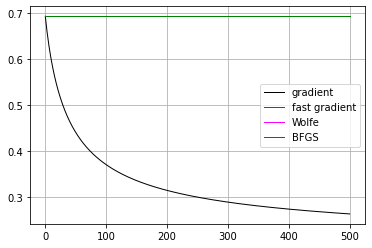

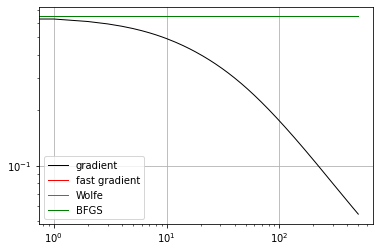

In [8]:
F = [pb.f(x_tab[i]) for i in range(x_tab.shape[0])]
G = [np.linalg.norm(pb.f_grad(x_tab[i] )) for i in range(x_tab.shape[0])]

FF = [pb.f(xF_tab[i]) for i in range(xF_tab.shape[0])]
GF = [np.linalg.norm(pb.f_grad(xF_tab[i] )) for i in range(xF_tab.shape[0])]

FW = [pb.f(xW_tab[i]) for i in range(xW_tab.shape[0])]
GW = [np.linalg.norm(pb.f_grad(xW_tab[i] )) for i in range(xW_tab.shape[0])]

FB = [pb.f(xB_tab[i]) for i in range(xB_tab.shape[0])]
GB = [np.linalg.norm(pb.f_grad(xB_tab[i] )) for i in range(xB_tab.shape[0])]


plt.figure()
plt.plot( F, color="black", linewidth=1.0, linestyle="-",label='gradient')
plt.plot( FF, color="red", linewidth=1.0, linestyle="-",label='fast gradient')
plt.plot( FW, color="magenta", linewidth=1.0, linestyle="-",label='Wolfe')
plt.plot( FB, color="green", linewidth=1.0, linestyle="-",label='BFGS')
plt.grid(True); plt.legend(); plt.show()


plt.figure()
plt.plot( G, color="black", linewidth=1.0, linestyle="-",label='gradient')
plt.plot( GF, color="red", linewidth=1.0, linestyle="-",label='fast gradient')
plt.plot( GW, color="magenta", linewidth=1.0, linestyle="-",label='Wolfe')
plt.plot( GB, color="green", linewidth=1.0, linestyle="-",label='BFGS')
plt.yscale('log'); plt.xscale('log'); 
plt.grid(True); plt.legend(); plt.show()

---

# Performance on learning problems

### Prediction power



Our problem of interest is binary classification using logistic regression.</br>
Although this is a machine learning task, the predictor construction amounts to minimizing a smooth convex optimization function $f$ called the *loss*, the final minimizer is called a *predictor* and its scalar product with the data vector gives a probability of belonging to class $1$.

The previous test was based on the functional decrease whereas our task is binary classification. Let us look at the final accuracies obtained.

> **Task 7**: The file `logistic_regression.py` contains a `prediction` function that takes a *predictor* and resturn the accuracy of the predictor. Take a look at how the function is defined.

> **Task 8**: Observe the accuracy of all final points obtained before. What do you notice? 

In [9]:
pred,perf = pb.prediction(x,PRINT=False)
print("Gradient algorithm: \t{:.2f}%".format(perf*100))

predF,perfF = pb.prediction(xF,PRINT=False)
print("Fast Gradient: \t\t{:.2f}%".format(perfF*100))

predW,perfW = pb.prediction(xW,PRINT=False)
print("Wolfe: \t\t\t{:.2f}%".format(perfW*100))

predB,perfB = pb.prediction(xB,PRINT=False)
print("BFGS: \t\t\t{:.2f}%".format(perfB*100))

Gradient algorithm: 	90.03%
Fast Gradient: 		35.90%
Wolfe: 			35.90%
BFGS: 			35.90%


In [10]:
predF,perfF = pb.prediction(xF,PRINT=True)

True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confidence: 100.0%)	False
True class: -1 	-- Predicted: -1 	(confidence: 100.0%)	True
True class: 1 	-- Predicted: -1 	(confid